<a href="https://colab.research.google.com/github/lusgaoliveira/imputacao-de-dados-e-previsao-com-redes-neurais/blob/main/imputacao-de-dados-e-previsao-com-redes-neurais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from metrics import mase, mape, smape, mpe, seasonal_mase

# Importando o dataset e tratando

> Add blockquote



In [4]:
# Carrega os dados
data = pd.read_csv("data/dados_dias.csv", sep=";", skiprows=9)

In [5]:
data.columns

Index(['Data Medicao', 'PRECIPITACAO TOTAL, DIARIO (AUT)(mm)',
       'PRESSAO ATMOSFERICA MEDIA DIARIA (AUT)(mB)',
       'TEMPERATURA DO PONTO DE ORVALHO MEDIA DIARIA (AUT)(°C)',
       'TEMPERATURA MAXIMA, DIARIA (AUT)(°C)',
       'TEMPERATURA MEDIA, DIARIA (AUT)(°C)',
       'TEMPERATURA MINIMA, DIARIA (AUT)(°C)',
       'UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)',
       'UMIDADE RELATIVA DO AR, MINIMA DIARIA (AUT)(%)',
       'VENTO, RAJADA MAXIMA DIARIA (AUT)(m/s)',
       'VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)', 'Unnamed: 11'],
      dtype='object')

In [6]:
data = data.drop(columns=['Unnamed: 11'], errors='ignore')

In [7]:
# Renomear as colunas
data.columns = ['Data', 'PrecipitacaoTotalDiaria (AUT)(mm)', 'PressaoMediaDiaria (AUT)(mB)', 'TempPontoOrvalho (AUT)(°C)',
                'TempMaxima (AUT)(°C)', 'TempMedia (AUT)(°C)', 'TempMinima (AUT)(°C)', 'UmidadeMedia (AUT)(%)', 'UmidadeMinima (AUT)(%)',
                'VentoRajadaMaxima (AUT)(m/s)', 'VentoVelocidadeMedia (AUT)(m/s)']

In [8]:
data.head()

,Data,PrecipitacaoTotalDiaria (AUT)(mm),PressaoMediaDiaria (AUT)(mB),TempPontoOrvalho (AUT)(°C),TempMaxima (AUT)(°C),TempMedia (AUT)(°C),TempMinima (AUT)(°C),UmidadeMedia (AUT)(%),UmidadeMinima (AUT)(%),VentoRajadaMaxima (AUT)(m/s),VentoVelocidadeMedia (AUT)(m/s)
0,2009-06-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,"8,9",NaN
1,2009-06-26,NaN,"986,7","18,2",29,"21,7",17,"80,4",50.0,"5,2","1,4"
2,2009-06-27,0,"988,4",19,28,"22,6","18,9","81,6",52.0,"7,6","1,7"
3,2009-06-28,0,"987,3","18,8",27,"21,9","19,2","83,5",55.0,"5,9","1,4"
4,2009-06-29,0,"985,3","18,4","28,5","22,3","18,6","80,8",48.0,"5,5","1,3"


In [9]:
# df["Data"] = pd.to_datetime(df["Data"])  # Converte para datetime
# df = df.set_index("Data")
# df = df.sort_index()

In [10]:
# Converter 'Data' para datetime e usar como índice
data['Data'] = pd.to_datetime(data['Data'], errors='coerce')
data = data.set_index('Data')
data = data.sort_index()

data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5669 entries, 2009-06-25 to 2024-12-31
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PrecipitacaoTotalDiaria (AUT)(mm)  4531 non-null   object 
 1   PressaoMediaDiaria (AUT)(mB)       5098 non-null   object 
 2   TempPontoOrvalho (AUT)(°C)         5075 non-null   object 
 3   TempMaxima (AUT)(°C)               5108 non-null   object 
 4   TempMedia (AUT)(°C)                5057 non-null   object 
 5   TempMinima (AUT)(°C)               5109 non-null   object 
 6   UmidadeMedia (AUT)(%)              5137 non-null   object 
 7   UmidadeMinima (AUT)(%)             5293 non-null   float64
 8   VentoRajadaMaxima (AUT)(m/s)       5203 non-null   object 
 9   VentoVelocidadeMedia (AUT)(m/s)    5007 non-null   object 
dtypes: float64(1), object(9)
memory usage: 487.2+ KB


In [11]:
colunas_para_converter = [
    'PrecipitacaoTotalDiaria (AUT)(mm)', 'PressaoMediaDiaria (AUT)(mB)', 'TempPontoOrvalho (AUT)(°C)',
    'TempMaxima (AUT)(°C)', 'TempMedia (AUT)(°C)', 'TempMinima (AUT)(°C)', 'UmidadeMedia (AUT)(%)', 'UmidadeMinima (AUT)(%)',
    'VentoRajadaMaxima (AUT)(m/s)', 'VentoVelocidadeMedia (AUT)(m/s)'
]

In [12]:
# A grande maioria dos valores das colunas está usando "vírgula" e não ".". Essa função cuida da conversão para o formato correto
def remove_virgula(value):
    if isinstance(value, str):
        try:
            return float(value.replace(',', '.'))
        except ValueError:
            return value
    return value

In [13]:
for col in colunas_para_converter:
    data[col] = data[col].map(remove_virgula)

In [14]:
data.info()
print(data.isnull().sum())

data = data.fillna(data.select_dtypes(include=['number']).mean())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5669 entries, 2009-06-25 to 2024-12-31
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PrecipitacaoTotalDiaria (AUT)(mm)  4531 non-null   float64
 1   PressaoMediaDiaria (AUT)(mB)       5098 non-null   float64
 2   TempPontoOrvalho (AUT)(°C)         5075 non-null   float64
 3   TempMaxima (AUT)(°C)               5108 non-null   float64
 4   TempMedia (AUT)(°C)                5057 non-null   float64
 5   TempMinima (AUT)(°C)               5109 non-null   float64
 6   UmidadeMedia (AUT)(%)              5137 non-null   float64
 7   UmidadeMinima (AUT)(%)             5293 non-null   float64
 8   VentoRajadaMaxima (AUT)(m/s)       5203 non-null   float64
 9   VentoVelocidadeMedia (AUT)(m/s)    5007 non-null   float64
dtypes: float64(10)
memory usage: 487.2 KB
PrecipitacaoTotalDiaria (AUT)(mm)    1138
PressaoMediaDiaria (AU

## 2. Estatísticas

In [15]:
# Usar o DataFrame original (já tratadas)
df_eda = data.copy()

# Estatísticas descritivas
print("Resumo estatístico:")
print(df_eda.describe())

Resumo estatístico:


       PrecipitacaoTotalDiaria (AUT)(mm)  PressaoMediaDiaria (AUT)(mB)  \
count                        5669.000000                   5669.000000   
mean                            2.273317                    984.040624   
std                             6.800282                      3.011226   
min                             0.000000                    973.400000   
25%                             0.000000                    982.000000   
50%                             0.200000                    984.040624   
75%                             2.273317                    986.000000   
max                           123.400000                    994.300000   

       TempPontoOrvalho (AUT)(°C)  TempMaxima (AUT)(°C)  TempMedia (AUT)(°C)  \
count                  5669.00000           5669.000000          5669.000000   
mean                     18.30201             30.864742            24.207139   
std                       1.85753              3.123921             2.228601   
min          

### 2.1 Histograma

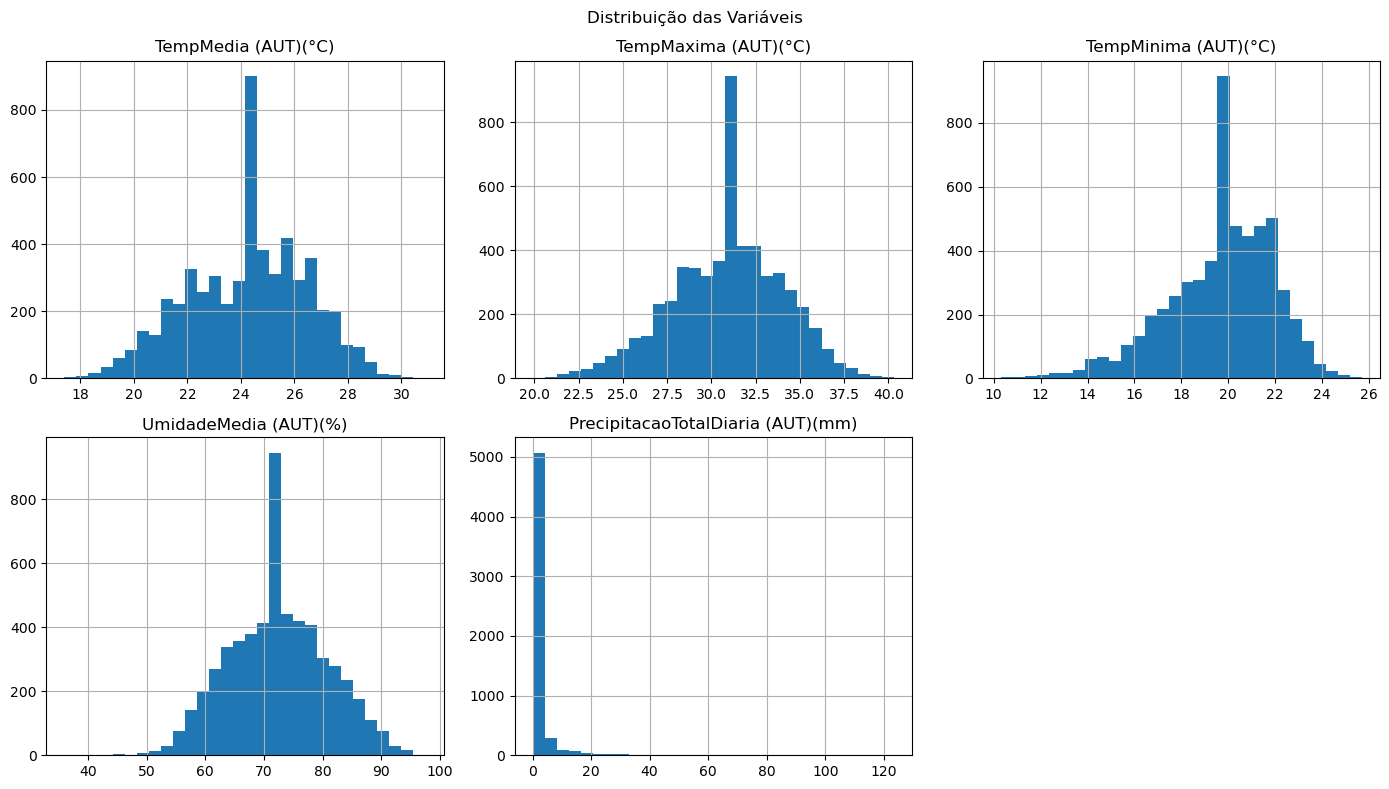

In [16]:
# Histograma das principais variáveis
variaveis_interesse = ['TempMedia (AUT)(°C)', 'TempMaxima (AUT)(°C)', 'TempMinima (AUT)(°C)',
                       'UmidadeMedia (AUT)(%)', 'PrecipitacaoTotalDiaria (AUT)(mm)']

df_eda[variaveis_interesse].hist(bins=30, figsize=(14, 8), layout=(2, 3))
plt.suptitle("Distribuição das Variáveis")
plt.tight_layout()
plt.show()

### 2.2 Boxplots

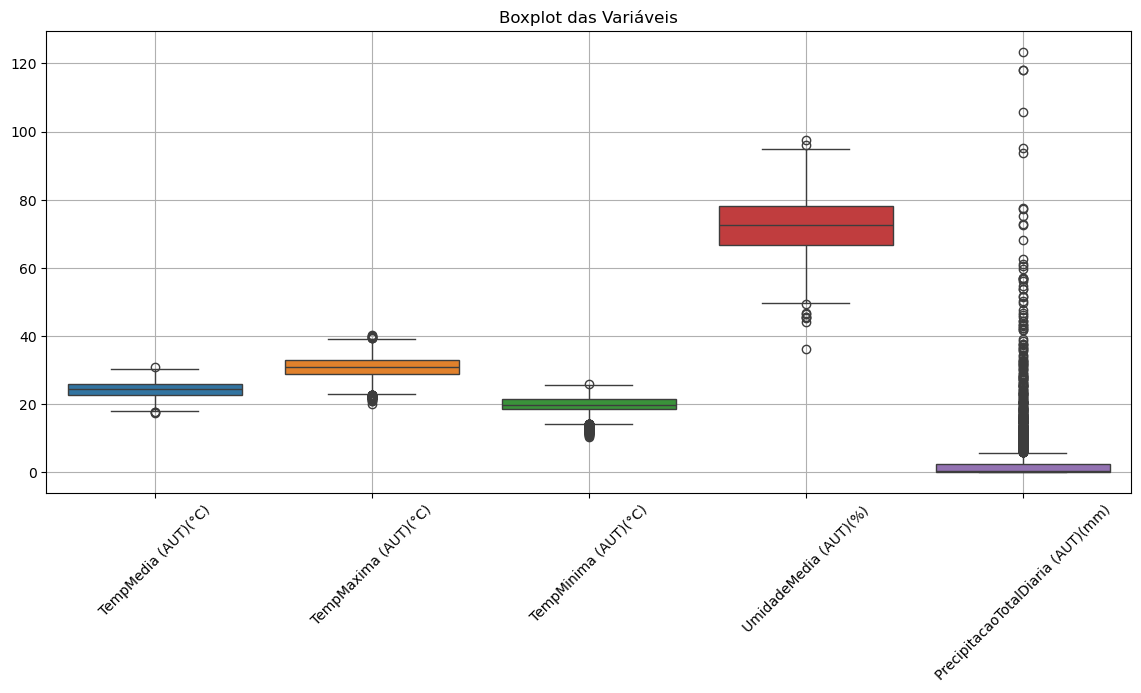

In [17]:
# Boxplots para detectar outliers
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_eda[variaveis_interesse])
plt.title("Boxplot das Variáveis")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 2.3 Mapa de Calor

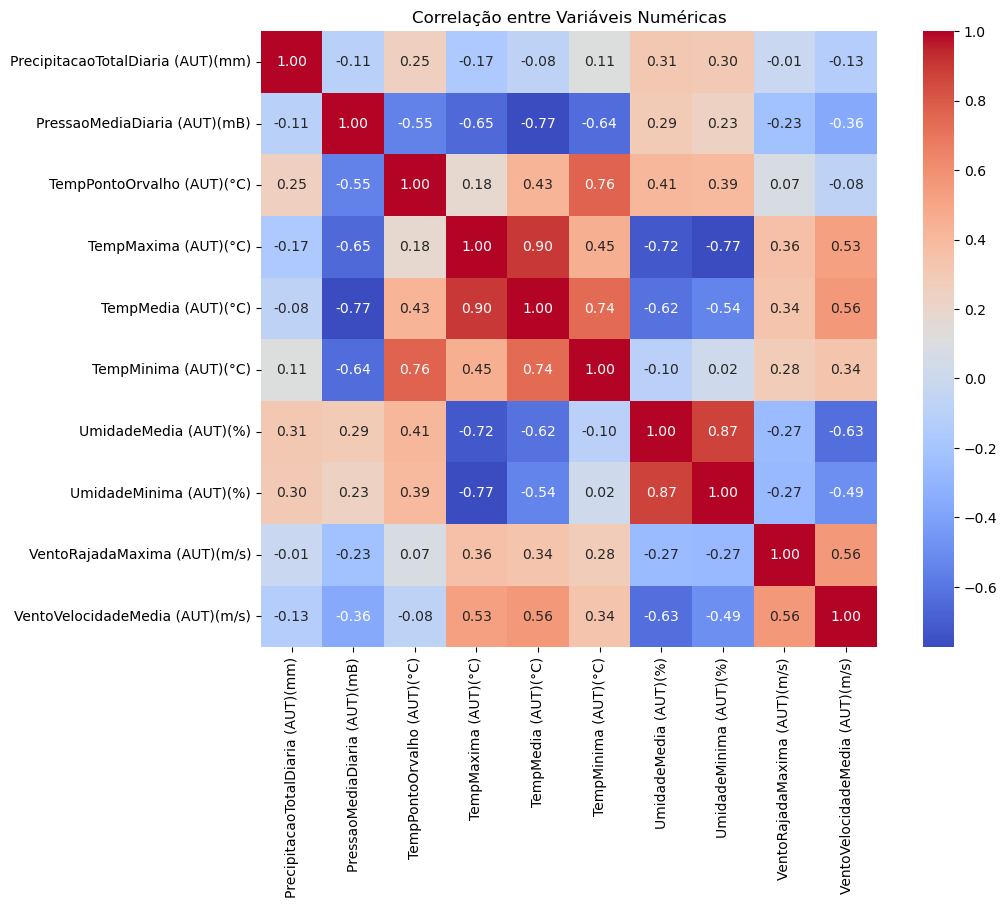

In [18]:
# Mapa de calor de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(df_eda.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlação entre Variáveis Numéricas")
plt.show()

### 2.4 Gráfico de Linha e Coluna

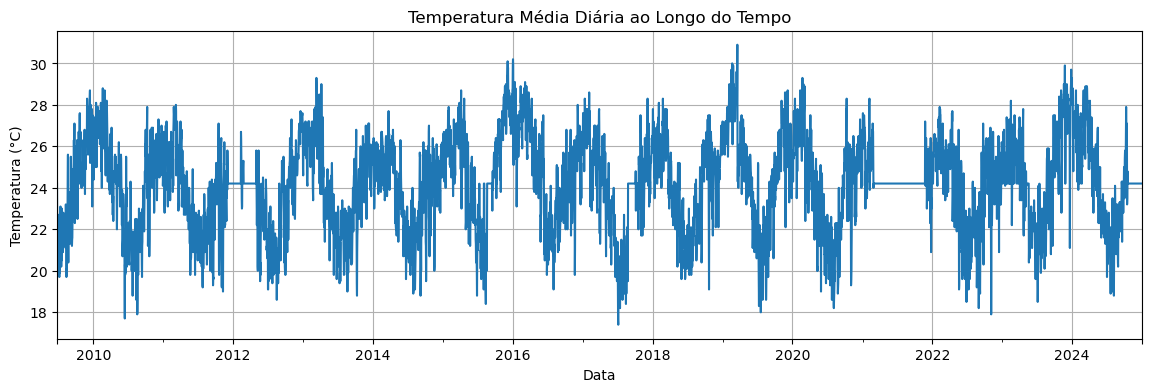

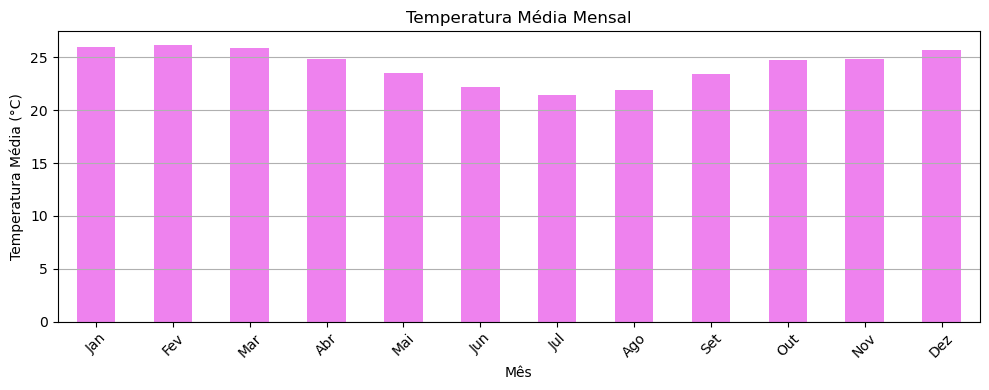

In [19]:

# Temperatura média ao longo do tempo
plt.figure(figsize=(14, 4))
df_eda['TempMedia (AUT)(°C)'].plot()
plt.title("Temperatura Média Diária ao Longo do Tempo")
plt.xlabel("Data")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.show()

# Temperatura média por mês (sazonalidade)
df_eda['Mes'] = df_eda.index.month
media_mensal = df_eda.groupby('Mes')['TempMedia (AUT)(°C)'].mean()

plt.figure(figsize=(10, 4))
media_mensal.plot(kind='bar', color='violet')
plt.title("Temperatura Média Mensal")
plt.xlabel("Mês")
plt.ylabel("Temperatura Média (°C)")
plt.xticks(range(0, 12), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
                          'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'], rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### **Interpretação:** Analisando os histogramas, observa-se que a temperatura média tende a se concentrar entre 24 °C e 25 °C, a temperatura máxima entre 31 °C e 32,5 °C, a mínima entre 19 °C e 22 °C, e a umidade relativa média entre 70% e 80%. O boxplot revela que a temperatura média apresenta poucos outliers e distribuição aproximadamente simétrica, indicando estabilidade nos dados, enquanto as demais variáveis possuem maior número de outliers e maior dispersão entre os valores mínimos e máximos, embora sem indícios de anomalias preocupantes. O mapa de calor da correlação mostra que a temperatura máxima possui forte correlação positiva com a temperatura média (0,90), seguida da temperatura mínima (0,74), além de uma correlação negativa significativa entre a temperatura média e a pressão atmosférica média diária (-0,77). Já os gráficos de linha e colunas evidenciam que a temperatura média diária varia geralmente entre 24 °C e 25 °C, com picos em torno de 28 °C ao longo dos anos, enquanto a temperatura média mensal, ao agrupar os dados por mês, se mantém em torno de 25 °C, indicando um padrão sazonal relativamente estável.

## 3. Preparação

In [ ]:
def preprocess_with_all_imputations(data):
    data = data.copy()
    data.index = pd.to_datetime(data.index)

    # ==========================
    # 1. Criação de features temporais (tensorflow documentação)
    # ==========================
    data['Ano'] = data.index.year
    data['Mes'] = data.index.month
    data['Dia'] = data.index.day
    data['DiaSemana'] = data.index.dayofweek
    data['DiaAno'] = data.index.dayofyear

    print("Valores ausentes por coluna:\n", data.isnull().sum())

    imputations = {}

    # -------------------------------------------------------------------
    # 2. IMPUTAÇÕES BÁSICAS
    # -------------------------------------------------------------------

    ## 2.1 Forward fill
    imputations["ffill"] = data.fillna(method='ffill')

    ## 2.2 Rolling mean
    data_rolling = data.copy()
    for col in data.columns:
        if data[col].isnull().sum() > 0:
            data_rolling[col] = data[col].fillna(
                data[col].rolling(window=15, min_periods=1).mean()
            )
    imputations["rolling_mean"] = data_rolling

    ## 2.3 Geometric interpolation
    def geometric_interpolate(series):
        series = series.apply(lambda x: max(x, 1e-6) if pd.notnull(x) else np.nan)
        series = series.fillna(series.median())

        return np.exp(np.log(series).interpolate(method='linear'))

    data_geom = data.copy()
    for col in data.columns:
        if data[col].isnull().sum() > 0:
            data_geom[col] = geometric_interpolate(data[col])
    imputations["geometric"] = data_geom

    # -------------------------------------------------------------------
    # 3. IMPUTAÇÃO COM ARIMA
    # -------------------------------------------------------------------
    def arima_impute(series):
        series_filled = series.copy()

        # preenche temporariamente para rodar o ARIMA sem quebrar (talvez melhorar isso depois)
        temp = series.fillna(method="ffill").fillna(method="bfill")

        model = ARIMA(temp, order=(3, 1, 2))
        fitted = model.fit()

        pred = fitted.predict()

        # substitui apenas onde há NA
        series_filled[series.isnull()] = pred[series.isnull()]
        return series_filled

    data_arima = data.copy()
    for col in data.columns:
        if data[col].isnull().sum() > 0:
            data_arima[col] = arima_impute(data[col])
    imputations["arima"] = data_arima

    # -------------------------------------------------------------------
    # 4. IMPUTAÇÃO KNN
    # -------------------------------------------------------------------
    knn = KNNImputer(n_neighbors=5)
    data_knn = pd.DataFrame(
        knn.fit_transform(data),
        index=data.index,
        columns=data.columns
    )
    imputations["knn"] = data_knn

    # -------------------------------------------------------------------
    # 5. IMPUTAÇÃO PROPHET
    # -------------------------------------------------------------------
    def prophet_impute(series):
        df = pd.DataFrame({"ds": series.index, "y": series.values})

        # substituir NA por interpolação temporária linear
        df['y'] = df['y'].interpolate()

        model = Prophet()
        model.fit(df)

        future = model.make_future_dataframe(periods=0)
        forecast = model.predict(future)

        yhat = forecast['yhat'].values
        series_filled = series.copy()
        series_filled[series.isnull()] = yhat[series.isnull()]

        return series_filled

    data_prophet = data.copy()
    for col in data.columns:
        if data[col].isnull().sum() > 0:
            data_prophet[col] = prophet_impute(data[col])
    imputations["prophet"] = data_prophet

    # -------------------------------------------------------------------
    # 6. LEST (Locally Estimated Seasonal Trend)
    #     — usando STL decomposition
    # -------------------------------------------------------------------
    def lest_impute(series):
        series_tmp = series.fillna(method="ffill").fillna(method="bfill")

        stl = STL(series_tmp, period=365)
        result = stl.fit()

        trend = result.trend
        season = result.seasonal

        # Reconstrução
        reconstructed = trend + season

        filled = series.copy()
        filled[series.isnull()] = reconstructed[series.isnull()]

        return filled

    data_lest = data.copy()
    for col in data.columns:
        if data[col].isnull().sum() > 0:
            data_lest[col] = lest_impute(data[col])
    imputations["lest"] = data_lest

    # -------------------------------------------------------------------
    # Retornar dicionário com todas versões
    # -------------------------------------------------------------------
    return imputations

In [21]:
datasets = preprocess_with_all_imputations(data)

df_ffill    = datasets["ffill"]
df_roll     = datasets["rolling_mean"]
df_geom     = datasets["geometric"]
df_arima    = datasets["arima"]
df_knn      = datasets["knn"]
df_prophet  = datasets["prophet"]
df_lest     = datasets["lest"]

Valores ausentes por coluna:
 PrecipitacaoTotalDiaria (AUT)(mm)    0
PressaoMediaDiaria (AUT)(mB)         0
TempPontoOrvalho (AUT)(°C)           0
TempMaxima (AUT)(°C)                 0
TempMedia (AUT)(°C)                  0
TempMinima (AUT)(°C)                 0
UmidadeMedia (AUT)(%)                0
UmidadeMinima (AUT)(%)               0
VentoRajadaMaxima (AUT)(m/s)         0
VentoVelocidadeMedia (AUT)(m/s)      0
Ano                                  0
Mes                                  0
Dia                                  0
DiaSemana                            0
DiaAno                               0
dtype: int64


/tmp/ipykernel_52108/1567853684.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  imputations["ffill"] = data.fillna(method='ffill')


## 4. Treino

In [22]:
def train_and_evaluate(df, n_passos=90):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df['Ano'] = df.index.year
    df['Mes'] = df.index.month
    df['Dia'] = df.index.day
    df['DiaSemana'] = df.index.dayofweek
    df['DiaAno'] = df.index.dayofyear

    target_col = 'TempMedia (AUT)(°C)'
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    if target_col not in numeric_cols:
        raise ValueError(f"Coluna alvo '{target_col}' não encontrada.")
    numeric_cols.remove(target_col)

    df['Mes_sin'] = np.sin(2 * np.pi * df['Mes'] / 12)
    df['Mes_cos'] = np.cos(2 * np.pi * df['Mes'] / 12)
    df['DiaSemana_sin'] = np.sin(2 * np.pi * df['DiaSemana'] / 7)
    df['DiaSemana_cos'] = np.cos(2 * np.pi * df['DiaSemana'] / 7)
    df['DiaAno_sin'] = np.sin(2 * np.pi * df['DiaAno'] / 365)
    df['DiaAno_cos'] = np.cos(2 * np.pi * df['DiaAno'] / 365)

    all_features = numeric_cols + ['Mes_sin', 'Mes_cos', 'DiaSemana_sin', 'DiaSemana_cos', 'DiaAno_sin', 'DiaAno_cos']

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    df[all_features] = scaler_x.fit_transform(df[all_features])
    df[[target_col]] = scaler_y.fit_transform(df[[target_col]])

    X, y = [], []
    for i in range(n_passos, len(df)):
        X.append(df[all_features].iloc[i - n_passos:i].values.flatten())
        y.append(df[target_col].iloc[i])
    X, y = np.array(X), np.array(y)

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='linear', kernel_regularizer=l2(0.001)))

    #learning rate tá um pouco alto, mas quando coloco o valor padrão recomendado não fica legal
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-8, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)

    y_pred = model.predict(X_test).flatten()
    y_test = y_test.flatten()

    metrics = {
      'MSE': mean_squared_error(y_test, y_pred),
      'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
      'MAE': mean_absolute_error(y_test, y_pred),
      'R²': r2_score(y_test, y_pred),
      'MAPE': mape(y_test, y_pred),
      'SMAPE': smape(y_test, y_pred),
      'MPE': mpe(y_test, y_pred),
      'MASE': mase(y_test, y_pred, y_train),
    }
    model.summary()
    return model, scaler_x, scaler_y, all_features, df, metrics

## 5. Avaliação

In [23]:
# Treinando os modelos com os três métodos de imputação
result_ffill   = train_and_evaluate(df_ffill)
result_rolling = train_and_evaluate(df_roll)
result_geom    = train_and_evaluate(df_geom)
result_arima   = train_and_evaluate(df_arima)
result_knn     = train_and_evaluate(df_knn)
result_prophet = train_and_evaluate(df_prophet)
result_lest    = train_and_evaluate(df_lest)


# Criar tabela de comparação
resultados = pd.DataFrame({
    'Forward Fill':             result_ffill[-1],
    'Rolling Mean':            result_rolling[-1],
    'Interpolação Geométrica': result_geom[-1],
    'ARIMA':                   result_arima[-1],
    'KNN':                     result_knn[-1],
    'Prophet':                 result_prophet[-1],
    'LEST/STL':                result_lest[-1]

}).T

print("Comparação dos métodos de imputação:\n")
print(resultados)

/home/lucas/anaconda3/envs/imputacao/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │       115,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,669 (1.35 MB)

 Trainable params: 117,889 (460.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,780 (921.02 KB)

/home/lucas/anaconda3/envs/imputacao/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │       115,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,669 (1.35 MB)

 Trainable params: 117,889 (460.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,780 (921.02 KB)

/home/lucas/anaconda3/envs/imputacao/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │       115,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,669 (1.35 MB)

 Trainable params: 117,889 (460.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,780 (921.02 KB)

/home/lucas/anaconda3/envs/imputacao/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │       115,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,669 (1.35 MB)

 Trainable params: 117,889 (460.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,780 (921.02 KB)

/home/lucas/anaconda3/envs/imputacao/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │       115,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,669 (1.35 MB)

 Trainable params: 117,889 (460.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,780 (921.02 KB)

/home/lucas/anaconda3/envs/imputacao/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 64)             │       115,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,669 (1.35 MB)

 Trainable params: 117,889 (460.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,780 (921.02 KB)

/home/lucas/anaconda3/envs/imputacao/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │       115,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,669 (1.35 MB)

 Trainable params: 117,889 (460.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,780 (921.02 KB)

Comparação dos métodos de imputação:

                              MSE      RMSE       MAE        R²       MAPE  \
Forward Fill             0.011764  0.108461  0.084701  0.554714  21.389587   
Rolling Mean             0.013464  0.116033  0.091150  0.490363  23.699954   
Interpolação Geométrica  0.025156  0.158608  0.130116  0.047764  27.164291   
ARIMA                    0.012970  0.113888  0.087865  0.509038  22.549333   
KNN                      0.013198  0.114882  0.089186  0.500427  23.040323   
Prophet                  0.014308  0.119614  0.091889  0.458420  22.450611   
LEST/STL                 0.012821  0.113230  0.087263  0.514695  22.077919   

                             SMAPE        MPE      MASE  
Forward Fill             17.957502  -4.422804  1.498295  
Rolling Mean             19.351467  -7.152030  1.612368  
Interpolação Geométrica  27.200288  10.761089  2.301641  
ARIMA                    18.604138  -5.677304  1.554265  
KNN                      18.869243  -6.647858  

In [ ]:
print("Comparação dos métodos de imputação:\n")
print(resultados)

rank_df = resultados.copy()

# Inverter métricas onde MAIOR = melhor
if 'R²' in rank_df.columns:
    rank_df['R²'] = -rank_df['R²']

ranking = rank_df.rank(method='average')

ranking['TOTAL'] = ranking.sum(axis=1)
melhor_metodo = ranking['TOTAL'].idxmin()

print("\nRanking multi-métrico:")
print(ranking)

print(f"\nMelhor método considerando TODAS as métricas: **{melhor_metodo}**")

model, scaler_x, scaler_y, all_features, df_melhor, _ = {
    'Forward Fill':             result_ffill,
    'Rolling Mean':            result_rolling,
    'Interpolação Geométrica': result_geom,
    'ARIMA':                   result_arima,
    'KNN':                     result_knn,
    'Prophet':                 result_prophet,
    'LEST/STL':                result_lest
}[melhor_metodo]

Comparação dos métodos de imputação:

                              MSE      RMSE       MAE        R²       MAPE  \
Forward Fill             0.011764  0.108461  0.084701  0.554714  21.389587   
Rolling Mean             0.013464  0.116033  0.091150  0.490363  23.699954   
Interpolação Geométrica  0.025156  0.158608  0.130116  0.047764  27.164291   
ARIMA                    0.012970  0.113888  0.087865  0.509038  22.549333   
KNN                      0.013198  0.114882  0.089186  0.500427  23.040323   
Prophet                  0.014308  0.119614  0.091889  0.458420  22.450611   
LEST/STL                 0.012821  0.113230  0.087263  0.514695  22.077919   

                             SMAPE        MPE      MASE  
Forward Fill             17.957502  -4.422804  1.498295  
Rolling Mean             19.351467  -7.152030  1.612368  
Interpolação Geométrica  27.200288  10.761089  2.301641  
ARIMA                    18.604138  -5.677304  1.554265  
KNN                      18.869243  -6.647858  